<a href="https://colab.research.google.com/github/emily1au/Team-9-Datathon4/blob/main/Datathon_4_code_restrict_data_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Import necessary libraries

In [57]:
!pip install category_encoders
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
import statsmodels.api as sm
from scipy import stats
from scipy.stats import norm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings

import torch as t
from torch.nn.functional import sigmoid, relu, tanh
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from torch.nn import Tanh, Linear, Sequential, Sigmoid, Dropout

import io

warnings.filterwarnings('ignore')


In [58]:
# check mising value
import missingno as msno

### 2. Load data

In [59]:
# Load dataset (Option 1)
data = pd.read_csv('datathon4.csv')

In [60]:
# Load dataset (Option 2)
# from google.colab import drive
# drive.mount('/content/drive')
# data = pd.read_csv('/content/drive/My Drive/CHL5230/Datathon #4/datathon4.csv')

In [61]:
# Load dataset (Option 3)
#from google.colab import files
# uploaded = files.upload()

In [ ]:
import io
pd.set_option('display.max_columns', None)
data = pd.read_csv(io.BytesIO(uploaded['datathon4.csv']))

In [63]:
# Load dictionary csv (need this to run the missing data visuaizations)
dictionary = pd.read_csv('datathon4-dictionary.csv')

### 3. Data exploration

In [ ]:
# Check all variables
for column in data.columns:
    print(column)

In [ ]:
# Examining Missing Data
print("Missing Value Distribution:")
pd.set_option('display.max_rows', 250)
missing_value_counts = data.isnull().sum()
missing_percentage = (missing_value_counts / len(data)) * 100
print(missing_percentage)

num_columns_over_50_missing = (missing_percentage > 50).sum()
print(f"Number of variables with more than 50% missing data: {num_columns_over_50_missing}") # 74 variables with >50% missing data

In [ ]:
# Visualize the missing data
for color, variable in enumerate(dictionary['Category'].unique()):
  if variable not in ['GOSSIS example prediction','identifier']:
    print(variable)
    col_list = list(dictionary[dictionary['Category']==variable]['Variable Name'].values)
    col_list = [f for f in col_list if f in data.columns]
    if len(col_list) > 0:
        msno.matrix(data[col_list].sample(1000),figsize=(10, 7), labels=True, color=(color/10, 1/(color+1), 0.5),  fontsize=14)
        msno.heatmap(data[col_list],figsize=(10, 10),labels=False,fontsize=14)
        plt.show()

In [67]:
# Removed variables with >50% missing data to avoid introducing bias to the model
columns_to_drop = missing_percentage[missing_percentage > 50].index
data.drop(columns_to_drop, axis=1, inplace=True)

In [68]:
# Basic descriptives
description = data.describe()
description

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,readmission_status,weight,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bun_apache,creatinine_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,resprate_apache,sodium_apache,temp_apache,ventilated_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
count,91713.000000,91713.000000,91713.000000,91713.000000,87485.000000,88284.000000,91713.000000,90379.000000,91713.000000,91713.000000,91713.0,88993.000000,90051.000000,90612.000000,91713.000000,90998.000000,72451.00000,72860.000000,89812.000000,89812.000000,90676.000000,89812.000000,80677.000000,90835.000000,71835.000000,90998.000000,90719.000000,90479.000000,73113.000000,87605.000000,90998.000000,69701.000000,91548.000000,91548.000000,90673.000000,90673.000000,91568.000000,91568.000000,91493.000000,91493.000000,90234.000000,90234.000000,91328.000000,91328.000000,91380.000000,91380.000000,91554.000000,91554.00000,90686.000000,90686.000000,89389.000000,89389.000000,88094.000000,88094.000000,84363.000000,84363.000000,88923.000000,88923.000000,87074.000000,87074.000000,82629.000000,82629.000000,87356.000000,87356.000000,87528.000000,87528.000000,88102.000000,88102.000000,84372.000000,84372.000000,69981.000000,69981.000000,81199.000000,81199.000000,78644.000000,78644.000000,81544.000000,81544.000000,85906.000000,85906.000000,76642.000000,76642.000000,79566.000000,79566.000000,80059.000000,80059.000000,78269.000000,78269.000000,82128.000000,82128.000000,81518.000000,81518.000000,78539.000000,78539.000000,83766.000000,83766.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000
mean,65606.079280,65537.131464,105.669262,0.086302,62.309516,29.185818,0.183736,169.641588,508.357692,0.835766,0.0,84.028340,185.401739,558.216377,0.201106,0.027979,25.82533,1.480014,3.465049,5.471195,0.009528,3.994778,160.326822,99.707932,32.988739,0.151223,88.015873,25.811007,137.966373,36.414472,0.325721,12.133333,88.491873,50.161314,88.610513,50.242597,103.000568,70.321848,104.651339,64.871859,104.590454,64.941541,28.882774,12.846279,99.241836,90.454826,148.339745,96.92387,148.235549,96.993313,37.284201,36.268391,75.354508,62.838150,75.805934,63.270616,92.229198,83.663720,91.612950,79.400028,91.594126,79.709315,22.633614,17.211525,98.044637,95.174310,133.247395,116.362296,133.054686,116.549625,36.710858,36.607651,25.685745,23.767469,8.378881,8.179575,1.488650,1.366947,174.638023,114.380940,24.366500,23.170486,11.448195,10.887875,34.531970,32.951813,207.105674,196.769779,4.251594,3.934658,139.124101,137.722144,12.476302,11.313536,0.086787,0.043955,0.000857,0.015693,0.225192,0.012989,0.026165,0.007066,

In [69]:
# Removed ID variables since it doesn't matter in the data
columns_to_drop = ['encounter_id', 'patient_id', 'hospital_id', 'icu_id']
data.drop(columns_to_drop, axis=1, inplace=True)

In [70]:
# Visual representation of outcome variable - Hospital deaths
counts = data['hospital_death'].value_counts()
colors = ['#1c3a73', '#7cb1c2']

fig = px.pie(
    names=counts.index,
    values=counts.values,
    hole=0.5,
    title='Distribution of Classes in "hospital_death"',
    color_discrete_sequence=colors
)

fig.update_layout(
    margin=dict(t=50, b=0, l=0, r=0),
    legend=dict(
        orientation="v",
        yanchor="top",
        y=0.5,
        xanchor="left",
        x=1.05,
        title='hospital_death'
    ),
    title=dict(
        text='Distribution of Classes in "hospital_death"',
        x=0.45,
        xanchor='center',
        y=0.95,
        yanchor='top',
        font=dict(size=16)
    ),
    width=500,
    height=350
)

fig.show()

# An 91.4-8.63 split suggests that there is a class imbalance in the dataset, with one class representing 91.4% of the data and the other only around 8.63%.

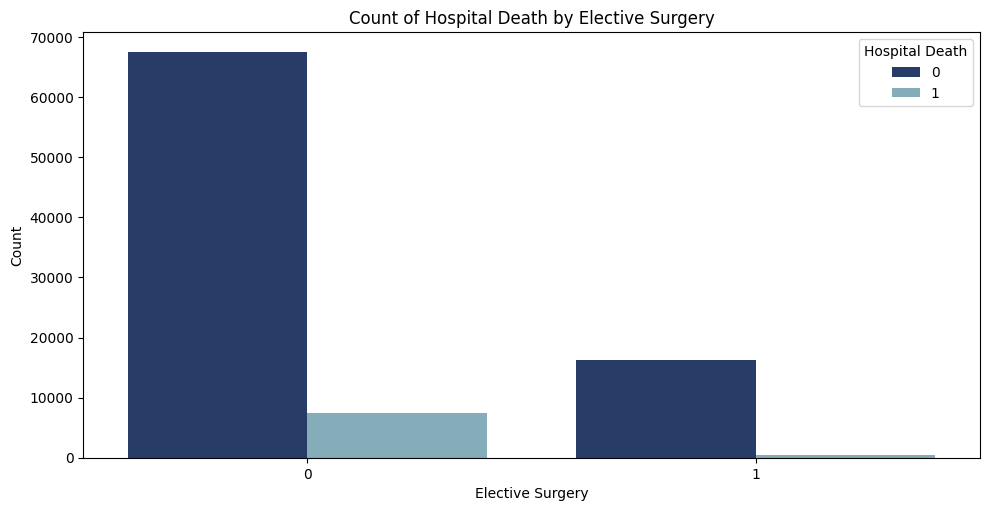

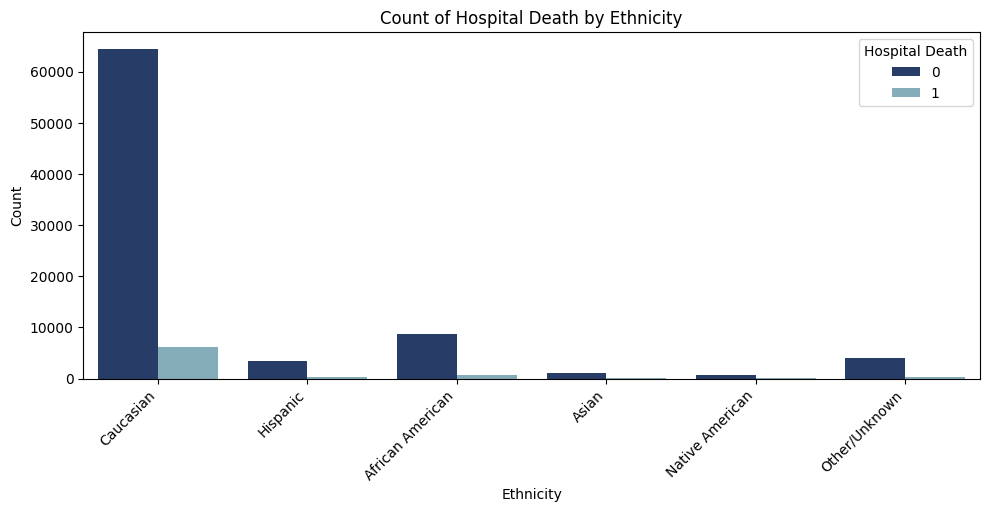

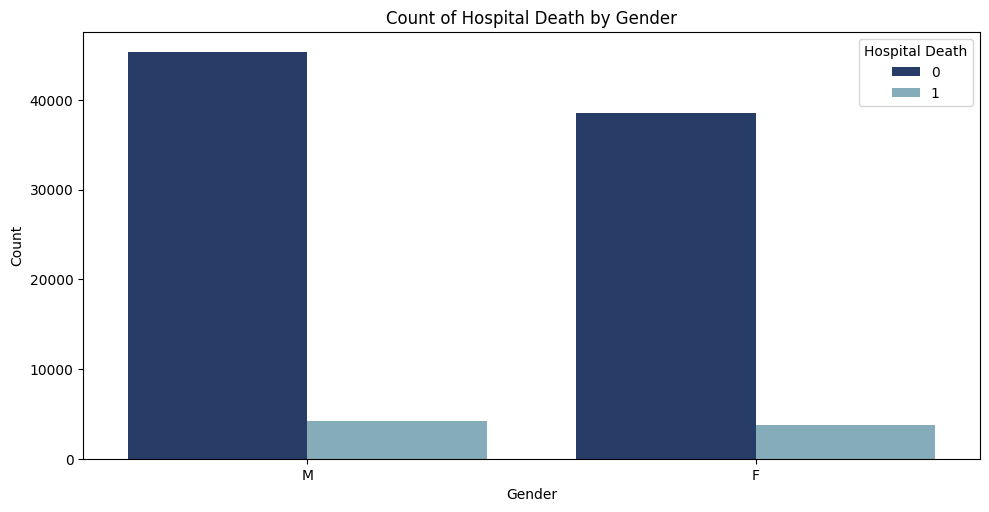

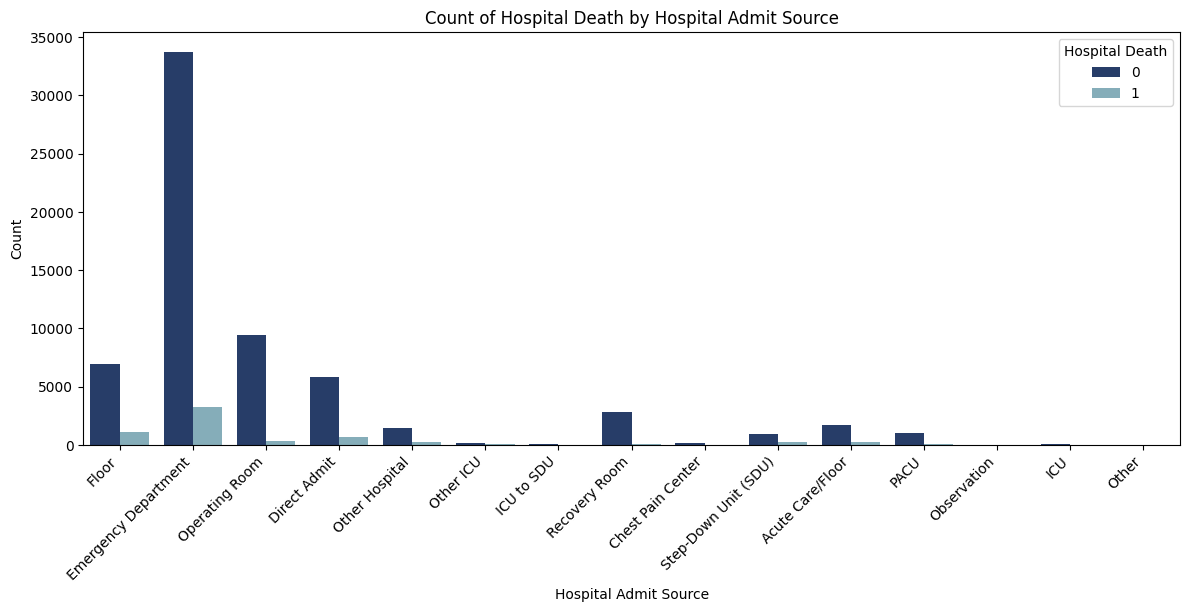

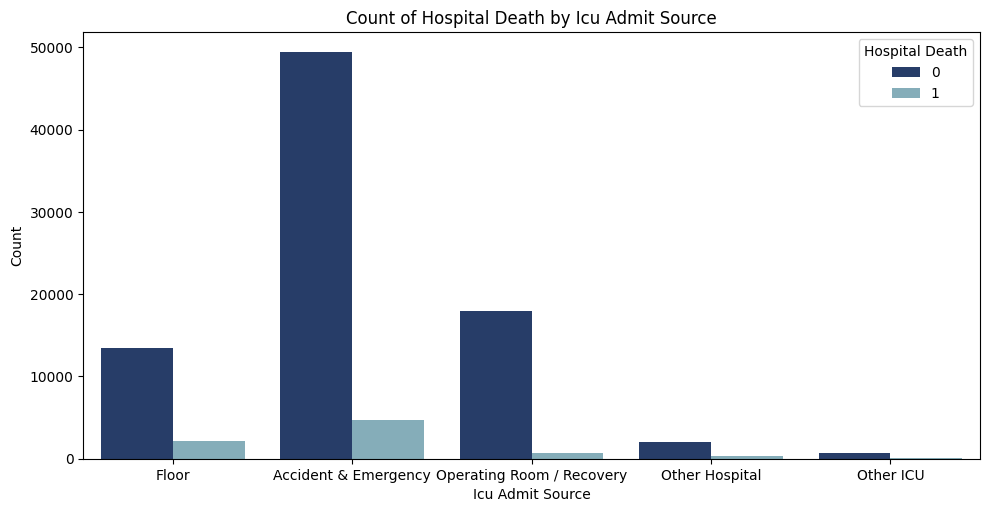

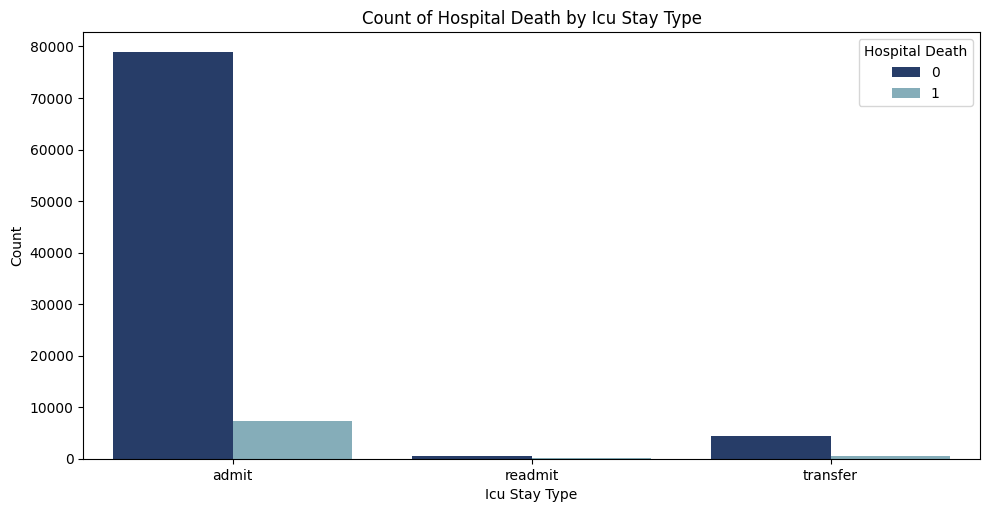

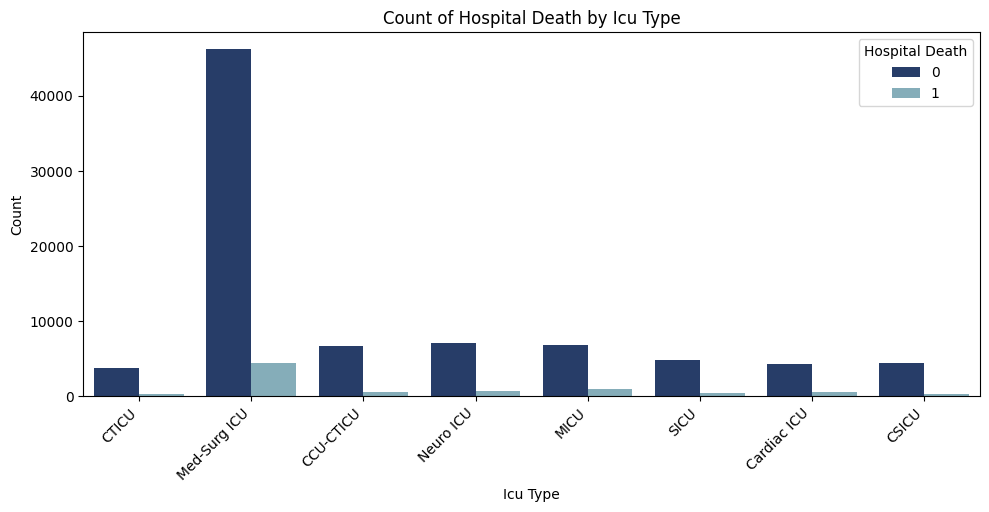

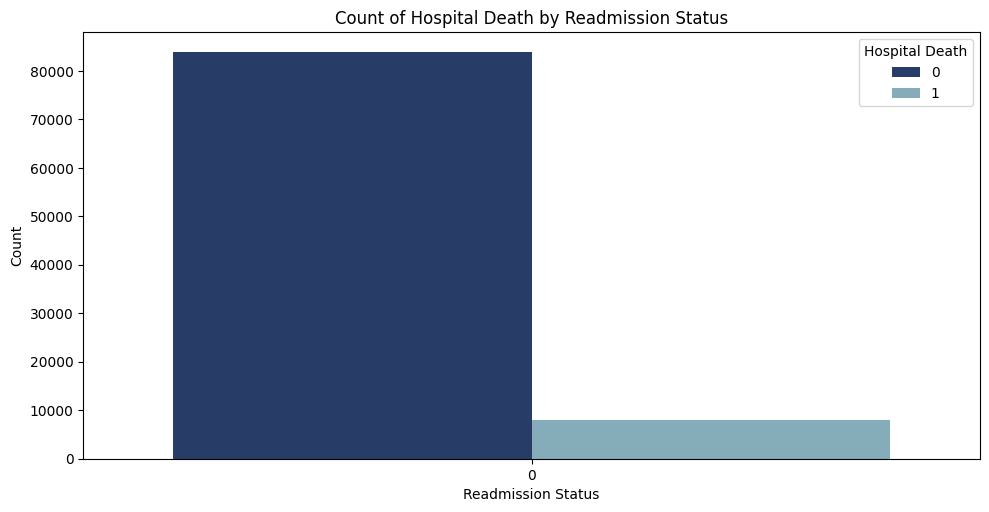

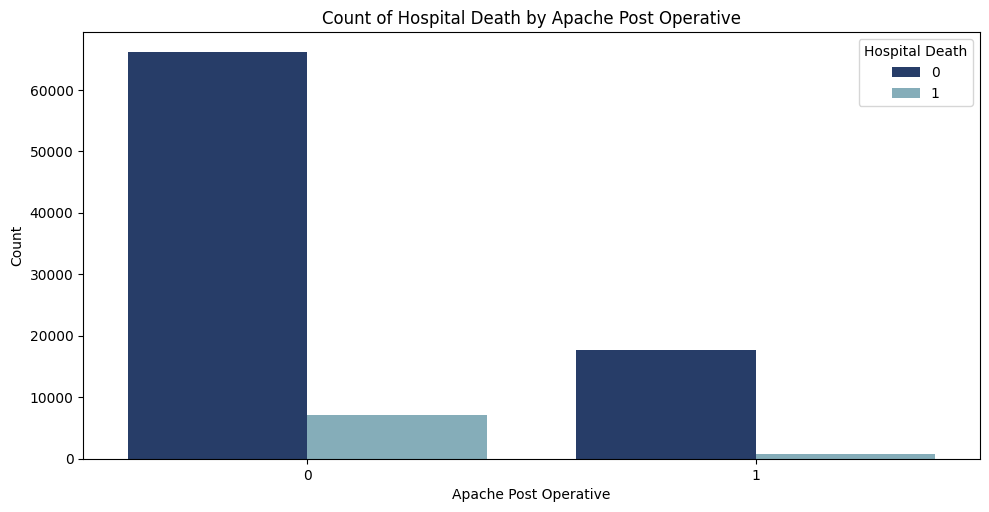

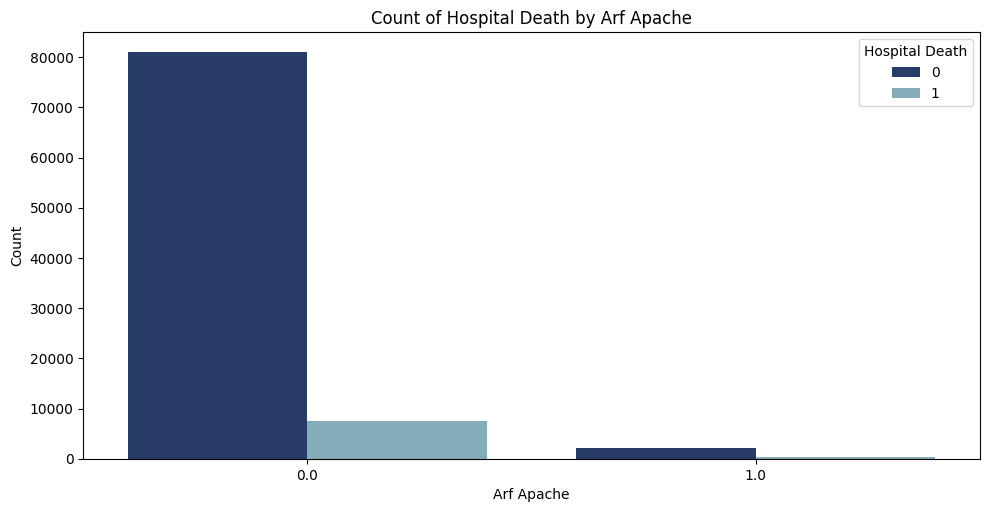

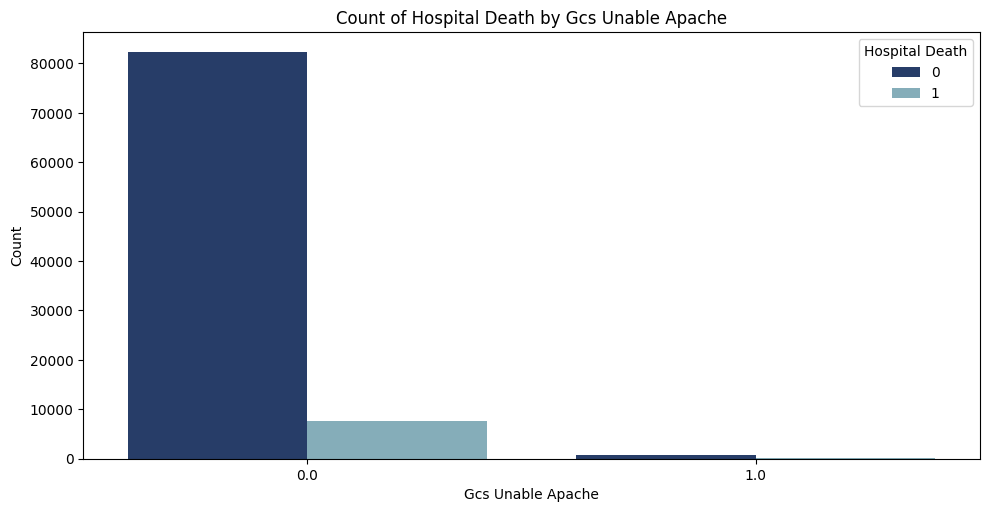

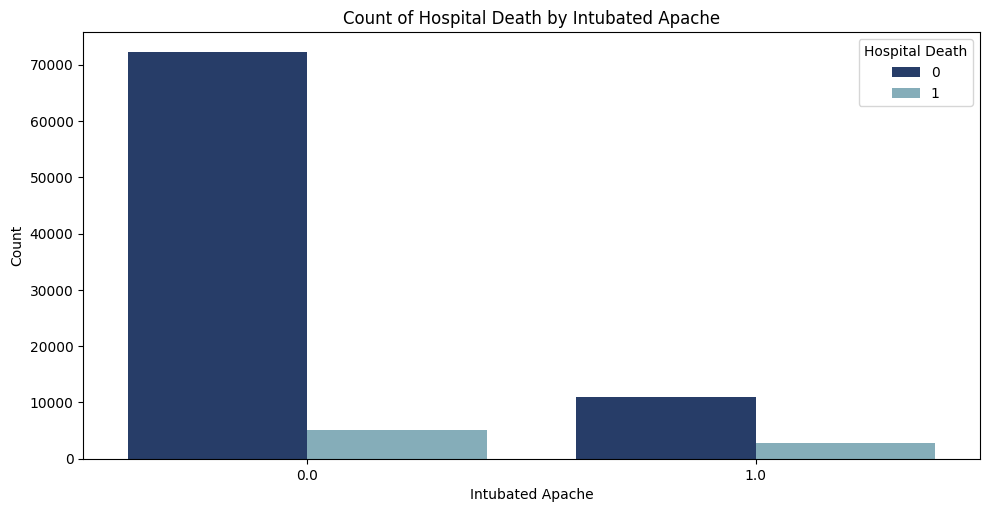

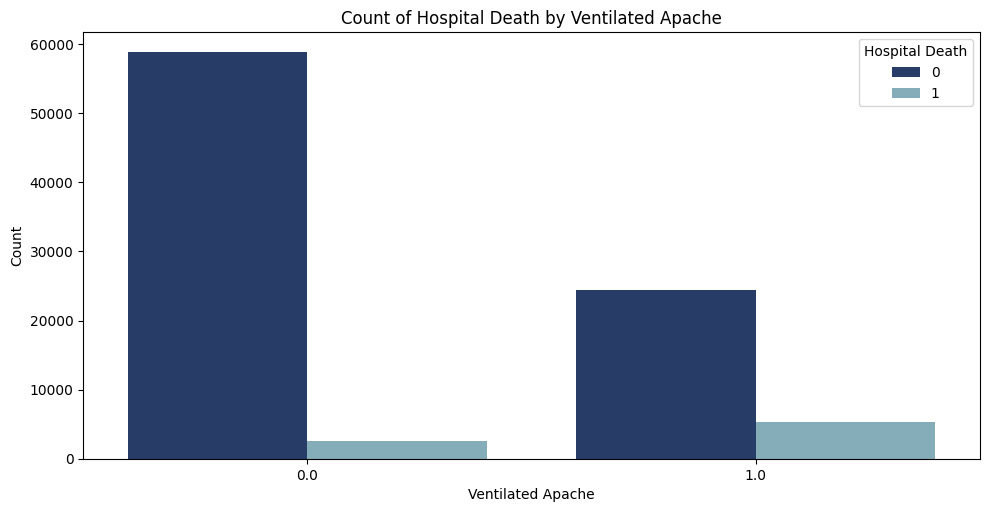

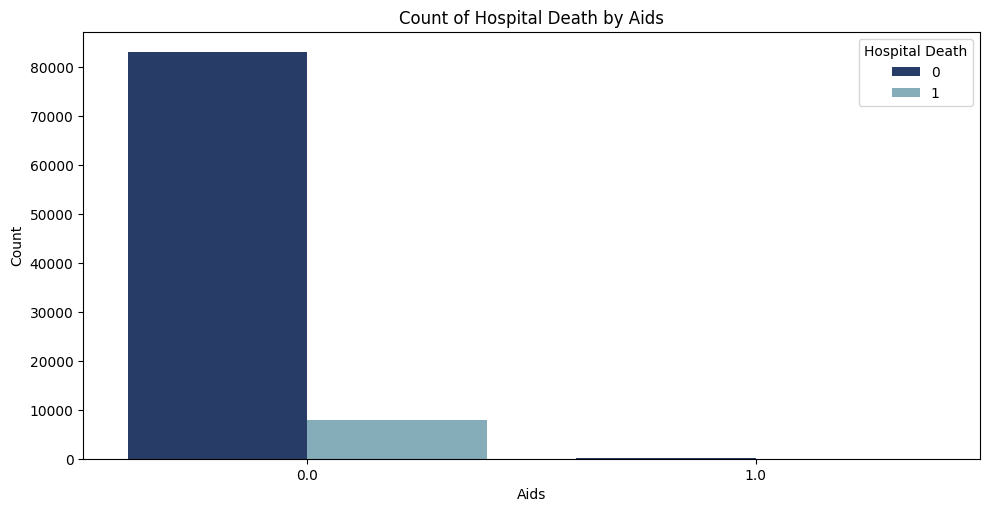

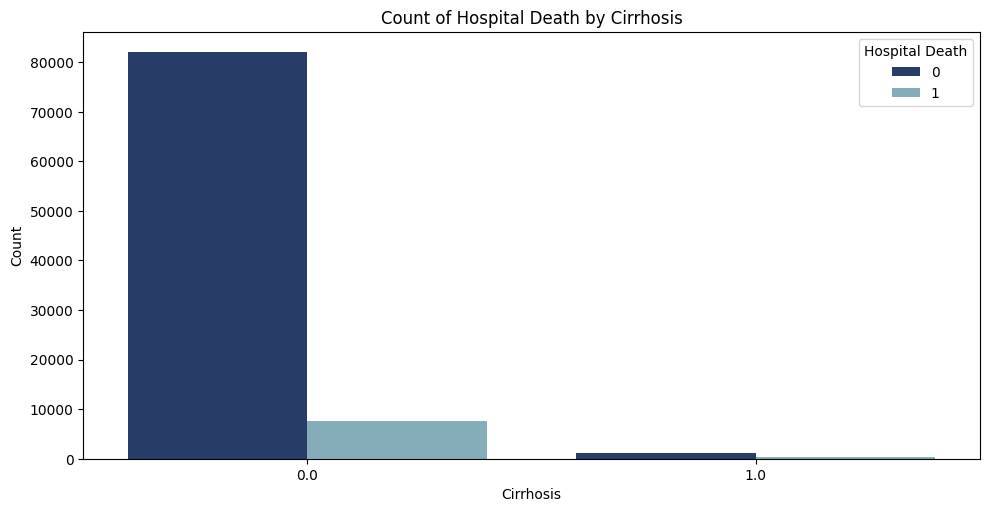

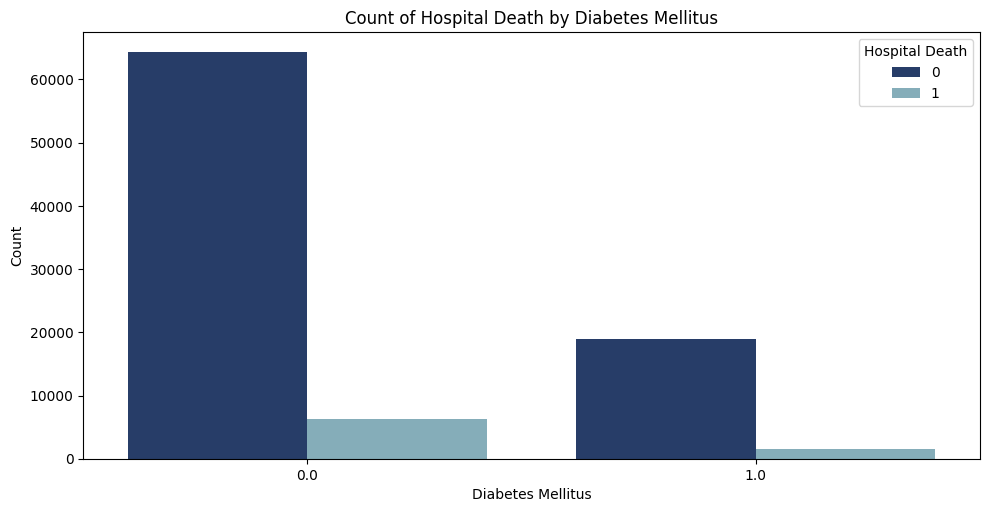

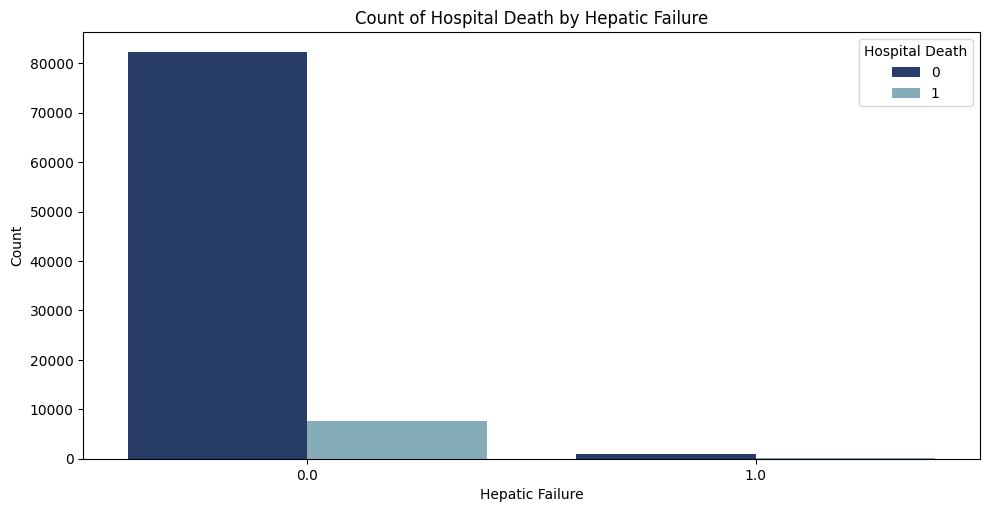

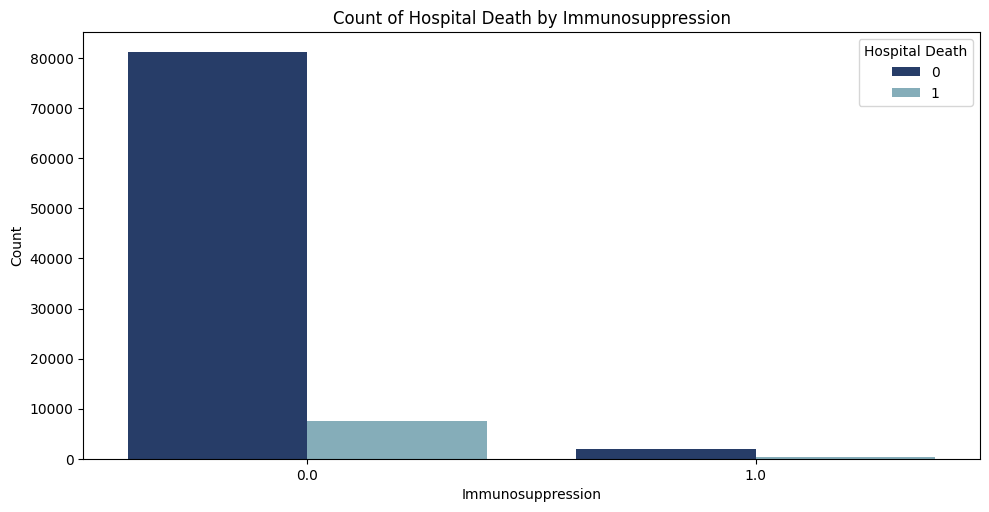

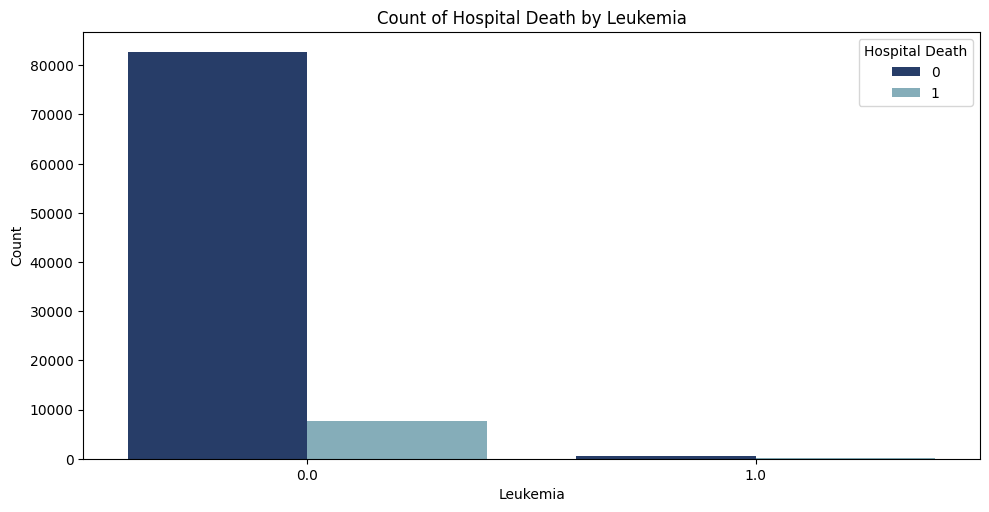

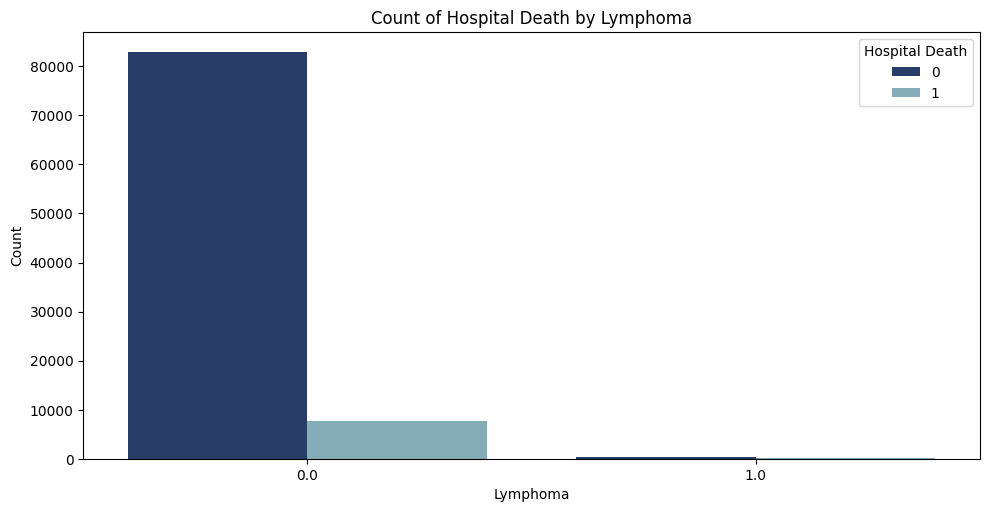

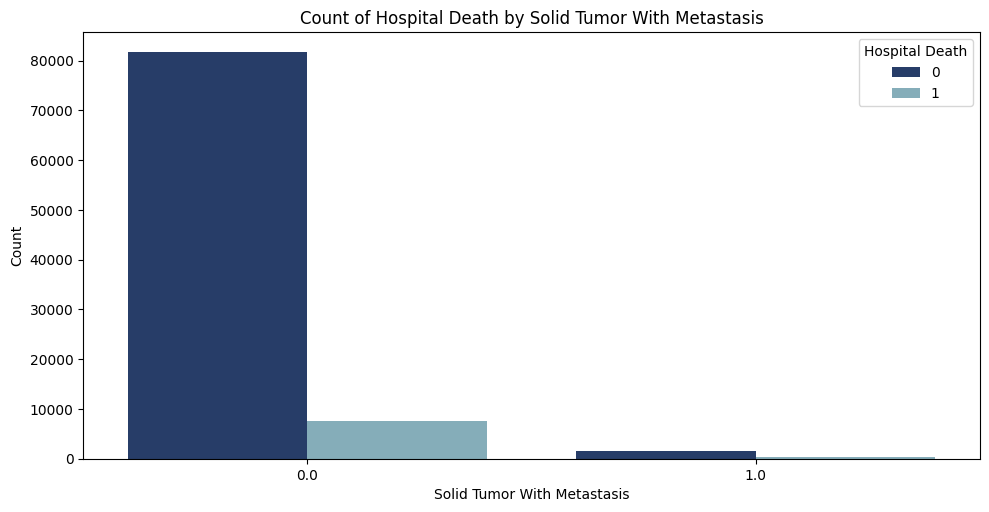

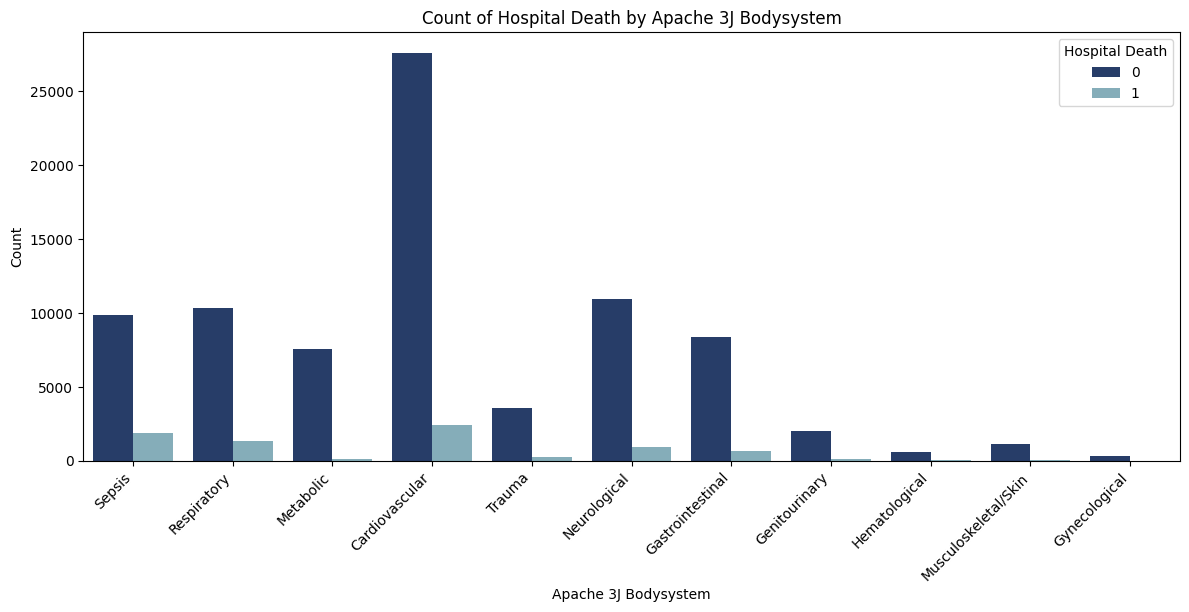

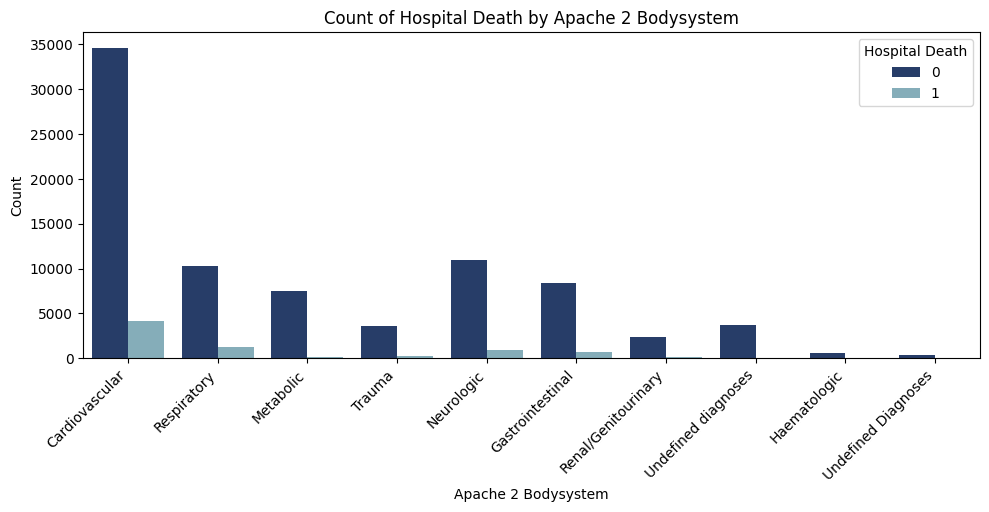

In [71]:
# Explore distribution of binary and categorical features
var = [
 'elective_surgery', 'ethnicity', 'gender',
    'hospital_admit_source', 'icu_admit_source', 'icu_stay_type',
    'icu_type', 'readmission_status', 'apache_post_operative',
    'arf_apache', 'gcs_unable_apache', 'intubated_apache',
    'ventilated_apache', 'aids', 'cirrhosis', 'diabetes_mellitus',
    'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma',
    'solid_tumor_with_metastasis', 'apache_3j_bodysystem', 'apache_2_bodysystem'
]

# Set up the colors for the plots
colors = ['#1c3a73', '#7cb1c2']

# Loop through the list and create count plots
for variable in var:
    # Set a larger figure size for variables with many categories
    n_categories = len(data[variable].dropna().unique())
    fig_width = 10
    fig_height = 5
    if n_categories > 10:
        fig_width = 12
        fig_height = 6
    if n_categories > 20:
        fig_width = 14
        fig_height = 8

    plt.figure(figsize=(fig_width, fig_height))
    ax = sns.countplot(data=data, x=variable, hue='hospital_death', palette=colors)

    # Rotate x-axis labels for better readability
    if n_categories > 5:
        plt.xticks(rotation=45, ha='right')

    # Improve layout for very long labels
    plt.tight_layout()

    # Set labels and title
    plt.xlabel(variable.replace('_', ' ').title())
    plt.ylabel('Count')
    plt.title(f'Count of Hospital Death by {variable.replace("_", " ").title()}')
    plt.legend(title='Hospital Death')

    # Show plot
    plt.show()

In [72]:
# Explore distribution of continuous variables
cont = [col for col in data.columns if col not in var]

for variable in cont:
    if data[variable].dtype in ['float64', 'int64']:  # Check if variable is numerical
        max_val = data[variable].max()
        min_val = data[variable].min()
        mean_val = data[variable].mean()
        print(f'Maximum value for {variable}: {max_val}')
        print(f'Minimum value for {variable}: {min_val}')
        print(f'Average value for {variable}: {mean_val:.2f}')
    else:
        print(f'Skipping {variable}, not a numerical data type.')
    print()

Maximum value for hospital_death: 1
Minimum value for hospital_death: 0
Average value for hospital_death: 0.09

Maximum value for age: 89.0
Minimum value for age: 16.0
Average value for age: 62.31

Maximum value for bmi: 67.81498973
Minimum value for bmi: 14.84492591
Average value for bmi: 29.19

Maximum value for height: 195.59
Minimum value for height: 137.2
Average value for height: 169.64

Maximum value for pre_icu_los_days: 159.0909722
Minimum value for pre_icu_los_days: -24.94722222
Average value for pre_icu_los_days: 0.84

Maximum value for weight: 186.0
Minimum value for weight: 38.6
Average value for weight: 84.03

Maximum value for apache_2_diagnosis: 308.0
Minimum value for apache_2_diagnosis: 101.0
Average value for apache_2_diagnosis: 185.40

Maximum value for apache_3j_diagnosis: 2201.05
Minimum value for apache_3j_diagnosis: 0.01
Average value for apache_3j_diagnosis: 558.22

Maximum value for bun_apache: 127.0
Minimum value for bun_apache: 4.0
Average value for bun_apac

### Data engineering (EL)

In [73]:
# Checking for missing values
missing_value_counts = data.isnull().sum()

# Replace "N/A" strings with NaN
data.replace("nan", np.nan, inplace=True)

# Calculate and replace missing values with the median
data.fillna(data.median(numeric_only=True).round(1), inplace=True)

print(missing_value_counts[missing_value_counts > 0])

age                               4228
bmi                               3429
ethnicity                         1395
gender                              25
height                            1334
hospital_admit_source            21409
icu_admit_source                   112
weight                            2720
apache_2_diagnosis                1662
apache_3j_diagnosis               1101
arf_apache                         715
bun_apache                       19262
creatinine_apache                18853
gcs_eyes_apache                   1901
gcs_motor_apache                  1901
gcs_unable_apache                 1037
gcs_verbal_apache                 1901
glucose_apache                   11036
heart_rate_apache                  878
hematocrit_apache                19878
intubated_apache                   715
map_apache                         994
resprate_apache                   1234
sodium_apache                    18600
temp_apache                       4108
ventilated_apache        

In [74]:
def pseudo1hot (categories, prefix, feature) :
  # Create a binary variable for each category
  for category in categories:
      data[prefix + category] = data[feature].apply(lambda x: 1 if x == category else 0)

  # Handle NaN values separately
  data[feature + '_nan'] = data[feature].isna().astype(int)

In [75]:
# Recode each category of ethnicity into its own binary variable without using one-hot encoding
categories = ['Caucasian', 'Hispanic', 'African American', 'Asian', 'Native American', 'Other/Unknown']
pseudo1hot(categories,'','ethnicity')


# Recode each category of hospital_admit_source into its own binary variable
categories = ['Floor', 'Emergency Department', 'Operating Room', 'Direct Admit', 'Other Hospital',
              'Other ICU', 'ICU to SDU', 'Recovery Room','Chest Pain Center']
pseudo1hot(categories,'has_','hospital_admit_source')


# Recode each category of icu_admit_source into its own binary variable
categories = ['Floor', 'Accident & Emergency', 'Operating Room / Recovery', 'Other Hospital', 'Other ICU']
pseudo1hot(categories,'ias_','icu_admit_source')


# Recode each category of apache_3j_bodysystem into its own binary variable
categories = ['Sepsis', 'Respiratory', 'Metabolic', 'Cardiovascular', 'Trauma',
              'Neurological', 'Gastrointestinal', 'Genitourinary', 'Hematological',
              'Musculoskeletal/Skin', 'Gynecological']
pseudo1hot(categories,'a3j_','apache_3j_bodysystem')



# Recode each category of apache_2_bodysystem into its own binary variable
categories = ['Cardiovascular', 'Respiratory', 'Metabolic', 'Trauma', 'Neurologic',
              'Gastrointestinal', 'Renal/Genitourinary', 'Undefined diagnoses','a2_Haematologic', 'Undefined Diagnoses']
pseudo1hot(categories,'a2_','apache_2_bodysystem')

In [76]:
# Recode each category of icu_stay_type into its own binary variable
categories = ['admit' 'readmit' 'transfer']
pseudo1hot(categories,'','icu_stay_type')

In [77]:
# Recode each category of icu_type into its own binary variable
categories = ['CTICU' 'Med-Surg ICU' 'CCU-CTICU' 'Neuro ICU' 'MICU' 'SICU'
 'Cardiac ICU' 'CSICU']
pseudo1hot(categories,'','icu_type')

In [78]:
# Recode gender to binary variable: 0 = M, 1 = F
data['gender'] = data['gender'].map({'M': 0, 'F': 1})

In [79]:
# Drop original features to avoid duplication
data = data.drop(['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'apache_3j_bodysystem', 'apache_2_bodysystem', 'icu_stay_type', 'icu_type'], axis=1)

In [80]:
# Checking for missing values
missing_value_counts = data.isnull().sum()

# Replace "N/A" strings with NaN
data.replace("nan", np.nan, inplace=True)

# Calculate and replace missing values with the median
data.fillna(data.median(numeric_only=True).round(1), inplace=True)

print(missing_value_counts[missing_value_counts > 0])

Series([], dtype: int64)


In [81]:
data.isnull().sum() # Confirm imputations ran successfully

hospital_death                                                 0
age                                                            0
bmi                                                            0
elective_surgery                                               0
height                                                         0
pre_icu_los_days                                               0
readmission_status                                             0
weight                                                         0
apache_2_diagnosis                                             0
apache_3j_diagnosis                                            0
apache_post_operative                                          0
arf_apache                                                     0
bun_apache                                                     0
creatinine_apache                                              0
gcs_eyes_apache                                                0
gcs_motor_apache         

In [82]:
num_variables = data.shape[1]
print("Number of variables:", num_variables)

Number of variables: 150


### Neural network model

In [83]:
# Import necessary libraries
import torch as t # importing PyTorch library as 't' for convenience

import numpy as np # importing other necessary libraries
from torch.nn.functional import sigmoid, relu, tanh
from torch.optim import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

from torch.nn import Tanh, Linear, Sequential, Sigmoid, Dropout # importing PyTorch modules for building neural networks

In [84]:
# Splitting the data into 70% training and 30% testing
train = data.sample(frac=0.7, random_state=10)
test = data.drop(train.index)

In [85]:
# Defining the input to the neuron - a single example with 3 features
X = np.array([
    [0, 1, 2]
])

# Defining the expected output for the given input
Y = np.array([
    [1]
])

In [86]:
# Initializing the weights randomly for 3 inputs and 1 output
W = t.randn((3,1))
print(W)
print(W.dtype) # Checking the data type of the weights tensor
print(W.shape) # Checking the shape of the weights tensor
print('===========')

# Initializing the bias as a tensor with a single zero element
B = t.zeros((1,1))
print(B)
print(B.dtype) # Checking the data type of the bias tensor
print(B.shape) # Checking the shape of the bias tensor

tensor([[-0.2753],
        [-0.3795],
        [-0.0269]])
torch.float32
torch.Size([3, 1])
tensor([[0.]])
torch.float32
torch.Size([1, 1])


In [87]:
# Converting the input array to a PyTorch Tensor and performing matrix multiplication with the weights
XW = t.Tensor(X) @ W
print(XW)

# Adding the bias to the result of the matrix multiplication
XW_B = XW + B
print(XW_B)

tensor([[-0.4333]])
tensor([[-0.4333]])


In [88]:
# Applying the hyperbolic tangent activation function element-wise to the result
output = tanh(XW_B)
print(output)

tensor([[-0.4080]])


In [89]:
 # Calculating the Mean Squared Error (MSE) loss between the predicted output and the actual output
loss = t.nn.functional.mse_loss(output, t.Tensor(Y))
print(loss)

tensor(1.9826)


In [90]:
def sigmoid(x):
    return 1 / (1 + t.exp(-x))
import torch as t
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt


In [91]:
# Defining multiple inputs for batch processing
X = t.Tensor([
    # A batch of examples with 3 features each
    [0, 5, 2],
    [0, 3, 4],
    # ...
]).type(t.float32)

# Defining the expected outputs for the batch of inputs (for a binary classification problem)
Y = t.Tensor([
    # Corresponding expected outputs (labels)
    [1],
    [1],
    # ...
]).type(t.float32)

# Initializing weights and bias with the requirement to compute gradients (for learning during training)
W = t.randn((3,1), requires_grad=True)
B = t.zeros((1,1), requires_grad=True).type(t.float32)

In [92]:
 #Defining the loss function for binary classification (Binary Cross-Entropy Loss)
loss_fn = t.nn.BCELoss()

# Setting up the optimizer (Adam) with the parameters to optimize (weights and bias) and the learning rate
learning_rate = 1
optimizer = Adam([W, B], lr=learning_rate)

In [93]:
# Defining the number of iterations for training and a list to keep track of loss values
number_of_iterations = 100
loss_list = []
for _ in range(number_of_iterations):

    # Forward pass: computing the predicted output using the sigmoid activation function
    out = sigmoid(X @ W  + B)

    # Calculating the loss
    loss = loss_fn(out.view(-1), Y.view(-1))

    # Recording the loss value for visualization
    loss_list.append(loss.item())

    # Clearing previous gradients before the backward pass
    optimizer.zero_grad()

    # Backward pass: computing gradients
    loss.backward()

    # Updating the weights and bias based on the gradients computed
    optimizer.step()

In [94]:
print(sigmoid(X @ W  + B).detach().numpy())


[[1.]
 [1.]]


[[1.]
 [1.]]


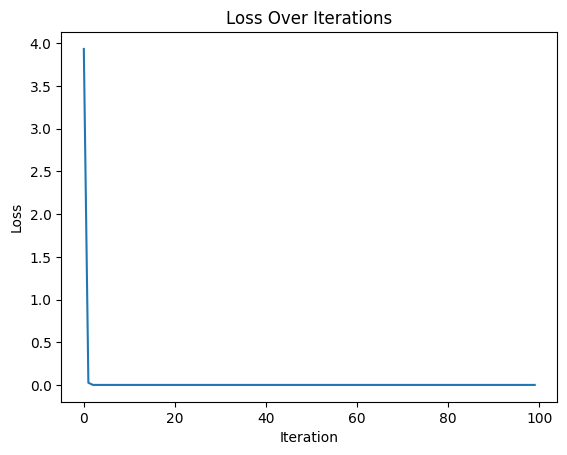

In [95]:
# Printing the probabilities predicted by the neuron for each input
print(sigmoid(X @ W  + B).detach().numpy())

# Visualizing Loss Over Iterations
# Plotting the loss values recorded during training
plt.plot([i for i in range(len(loss_list))], loss_list)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Over Iterations')
plt.show()


In [96]:
# Define the number of neurons in the first and second hidden layers
hidden_units_layer_1 = 5
hidden_units_layer_2 = 5

# FIRST LAYER: Define weights and biases for the first layer
W1 = t.randn((149, hidden_units_layer_1), requires_grad=True)
B1 = t.zeros((1, hidden_units_layer_1), requires_grad=True)

# SECOND LAYER: Define weights and biases for the second layer
W2 = t.randn((hidden_units_layer_1, hidden_units_layer_2), requires_grad=True)
B2 = t.zeros((1, hidden_units_layer_2), requires_grad=True)

# THIRD LAYER: Define weights and biases for the output layer
W3 = t.randn((hidden_units_layer_2, 1), requires_grad=True)
B3 = t.zeros((1, 1), requires_grad=True)

In [97]:
# Define the forward pass of the neural network
def forward(input):
    # First hidden layer with tanh activation
    out = tanh(input @ W1 + B1)

    # Second hidden layer with tanh activation
    out = tanh(out @ W2 + B2)

    # Output layer with sigmoid activation (since it's a binary classification problem)
    out = sigmoid(out @ W3 + B3)
    return out

In [98]:
# Randomly sample 70% of the data for training
train_data = data.sample(frac = .7, random_state=10)

In [99]:
# Use the remaining 30% for testing
test_data = data.drop(train_data.index)

# Check the mean of the 'DEATH_EVENT' column in both training and testing data
train_data['hospital_death'].mean()
test_data['hospital_death'].mean()

0.086610452860362

In [100]:
train_data.hospital_death.value_counts()

0    58667
1     5532
Name: hospital_death, dtype: int64

In [101]:
test_data.hospital_death.mean()

0.086610452860362

In [102]:
# Data Preparation

# Extract the 'DEATH_EVENT' column as the target variable for training and testing
Y_train = train_data['hospital_death'].to_numpy()
Y_test = test_data['hospital_death'].to_numpy()

# Extract the features (excluding 'DEATH_EVENT') for training and testing
X_train = train_data.drop('hospital_death', axis=1).to_numpy()
X_test = test_data.drop('hospital_death', axis=1).to_numpy()

In [103]:
# Standardize the features to have zero mean and unit variance
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [104]:
# Define the number of neurons in the first and second hidden layers
hidden_units_layer_1 = 5
hidden_units_layer_2 = 5

# FIRST LAYER: Define weights and biases for the first layer
W1 = t.randn((149, hidden_units_layer_1), requires_grad=True)
B1 = t.zeros((1, hidden_units_layer_1), requires_grad=True)

# SECOND LAYER: Define weights and biases for the second layer
W2 = t.randn((hidden_units_layer_1, hidden_units_layer_2), requires_grad=True)
B2 = t.zeros((1, hidden_units_layer_2), requires_grad=True)

# THIRD LAYER: Define weights and biases for the output layer
W3 = t.randn((hidden_units_layer_2, 1), requires_grad=True)
B3 = t.zeros((1, 1), requires_grad=True)

In [105]:
# Define the forward pass of the neural network
def forward(input):
    # First hidden layer with tanh activation
    out = tanh(input @ W1 + B1)

    # Second hidden layer with tanh activation
    out = tanh(out @ W2 + B2)

    # Output layer with sigmoid activation (since it's a binary classification problem)
    out = sigmoid(out @ W3 + B3)
    return out

In [106]:
# Assuming 'X_train' is your data array
print(np.unique(X_train.dtype))



[dtype('float64')]


In [107]:
import torch

# Convert NumPy array to a specific dtype (float64 in this case)
X_train_float32 = X_train.astype('float32')
Y_train_float32 = Y_train.astype('float32')

# Convert to PyTorch tensor
X = torch.tensor(X_train_float32)
Y = torch.tensor(Y_train_float32)


In [108]:
# Create a dataset from tensors to be used with DataLoader
train_dataset = TensorDataset(X, Y)

# Define training hyperparameters
epochs = 1000
learning_rate = 0.01
batch_size = 32

In [109]:
# DataLoader provides batches of data for training
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the optimizer (Adam) and include all weights and biases
optimizer = Adam([W1, B1, W2, B2, W3, B3], lr=learning_rate)

# Define the loss function (Binary Cross-Entropy Loss)
loss_fn = t.nn.BCELoss()

In [ ]:
train_loss_list = []

# Train the model for a specified number of epochs
for epoch in range(epochs):
    # Reduce the learning rate every 500 epochs
    if epoch % 500 == 0:
        learning_rate *= .9

    per_epoch_loss_list = []

    # Iterate over all batches of data
    for batch_idx, (X, Y) in enumerate(train_data_loader):
        # Forward pass: Compute predictions
        probs = forward(X)

        # Compute the loss
        loss = loss_fn(probs.view(-1), Y)

        # Backward pass: Compute gradient and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record the loss for this batch
        per_epoch_loss_list.append(loss.item())

    # Record the average loss for this epoch
    train_loss_list.append(sum(per_epoch_loss_list) / len(per_epoch_loss_list))

In [ ]:
print(train_loss_list)


In [ ]:
# Plot the training loss over epochs
plt.plot([i for i in range(len(train_loss_list))], train_loss_list)
plt.xlabel('epochs')
plt.ylabel('loss')

In [ ]:
import matplotlib.pyplot as plt

# Assuming train_loss_list is populated during training
# If the loss values are small, a scatter plot might help visualize individual points
plt.scatter(range(len(train_loss_list)), train_loss_list, marker='.')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs')

plt.show()


In [ ]:
print(train_loss_list)


In [ ]:
import torch as t  # Importing PyTorch library

try:
    # Disable gradient calculations for evaluation using t.no_grad()
    with t.no_grad():
        # Prepare the validation data
        X = t.tensor(X_test).type(t.float32)  # Convert validation features to a PyTorch tensor
        Y = t.tensor(Y_test).type(t.float32)  # Convert validation labels to a PyTorch tensor
except Exception as e:
    print("An error occurred:", e)


### Evaluate Model Performance on Validation Data

In [ ]:
# Disable gradient calculations for evaluation using t.no_grad()
with t.no_grad():
    # Prepare the validation data
    X = t.Tensor(X_test).type(t.float32)  # Convert validation features to a PyTorch tensor
    Y = t.Tensor(Y_test).type(t.float32)  # Convert validation labels to a PyTorch tensor

    # Calculate predictions on the validation data
    probs = forward(X)  # Pass validation data through the trained model
    loss = loss_fn(probs.view(-1), Y)  # Compute the loss between predictions and actual labels

    # Print the validation loss
    print(loss.item())

    # Now, evaluate the model on the training data
    X = t.Tensor(X_train).type(t.float32)  # Convert training features to a PyTorch tensor
    Y = t.Tensor(Y_train).type(t.float32)  # Convert training labels to a PyTorch tensor

    # Calculate predictions on the training data
    probs = forward(X)  # Pass training data through the trained model
    loss = loss_fn(probs.view(-1), Y)  # Compute the loss between predictions and actual labels

    # Print the training loss
    print(loss.item())

### Regularization training

In [ ]:
# Regularization
# Deep neural networks are prone to overfitting if there is not much data available during training.

# Define hyperparameters
number_of_input_features = 149
number_of_hidden_units = 5
epochs = 1000
learning_rate = 0.01
batch_size = 32
landa = 0.01  # Regularization term (lambda)

In [ ]:
# Prepare the data
X_train_tensor = t.Tensor(X_train).type(t.float32)
Y_train_tensor = t.Tensor(Y_train).type(t.float32)

X_test_tensor = t.Tensor(X_test).type(t.float32)
Y_test_tensor = t.Tensor(Y_test).type(t.float32)

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Define the neural network model with regularization
model = nn.Sequential(
    nn.Linear(number_of_input_features, number_of_hidden_units),  # Linear layer for matrix multiplication and bias addition
    nn.Tanh(),  # Tanh activation function
    nn.Linear(number_of_hidden_units, 1),  # Another linear layer
    nn.Sigmoid()  # Sigmoid activation for probability output
)

In [ ]:
# Define the optimizer
optimizer = Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Define the loss function with Binary Cross-Entropy Loss
loss_fn = nn.BCELoss()

In [ ]:
# Lists to store training accuracy, validation accuracy, and training loss over epochs
train_accuracy_list = []
validation_accuracy_list = []
train_loss_list = []

In [ ]:
for epoch in range(epochs):
    if epoch % 500 == 0:
        learning_rate *= 0.9  # Learning rate scheduling

    per_epoch_loss_list = []

    for batch_idx, (X, Y) in enumerate(train_data_loader):
        # Forward pass: Compute predictions
        probs = model(X)

        # Adding regularization term for all parameters in the model
        l2_term = sum([(w ** 2).sum() for w in model.parameters()])

        # New loss is the old loss + regularization term
        loss = loss_fn(probs.view(-1), Y) + landa * l2_term

        per_epoch_loss_list.append(loss.item())

        # Backward pass: Compute gradient and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

 # Evaluate the model on training and validation data
    with t.no_grad():
        # Set the model in eval mode; some layers use this for certain calculations during training
        model.eval()

        # Calculate accuracy on train data
        probs = model(X_train_tensor)
        prediction = (probs >= 0.5).type(t.LongTensor).view(-1)
        train_accuracy = (prediction == Y_train_tensor).type(t.float32).mean().item()

        # Calculate accuracy on validation data
        probs = model(X_test_tensor)
        prediction = (probs >= 0.5).type(t.LongTensor).view(-1)
        validation_accuracy = (prediction == Y_test_tensor).type(t.float32).mean().item()

        # Print accuracy for the current epoch
        print(f'Epoch {epoch}/{epochs} ---> Train Accuracy: {train_accuracy}, Validation Accuracy: {validation_accuracy}')

        # Set the model back to train mode
        model.train()

        # Append accuracy values to lists
        train_accuracy_list.append(train_accuracy)
        validation_accuracy_list.append(validation_accuracy)

# Calculate and append the average loss for the epoch
train_loss_list.append(sum(per_epoch_loss_list) / len(per_epoch_loss_list))

In [ ]:
# Plot training and validation accuracy over epochs
plt.plot([i for i in range(len(train_accuracy_list))], train_accuracy_list, label="Train")
plt.plot([i for i in range(len(validation_accuracy_list))], validation_accuracy_list, label="Validation")
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([0, len(train_accuracy_list) - 1])
plt.ylim([0, 1])
plt.show()

###Halting the overfit


In [ ]:
# Importing necessary libraries
import torch as t
from torch.utils.data import TensorDataset, DataLoader
from torch.nn import Sequential, Linear, Tanh, Sigmoid
from torch.optim import Adam
from torch.nn import BCELoss
import matplotlib.pyplot as plt

In [ ]:
# Defining the parameters
number_of_input_features = 149
number_of_hidden_units = 5
epochs = 1000
learning_rate = 0.01
batch_size = 32

In [ ]:
# Loading and preprocessing the data
X_train_tensor = t.Tensor(X_train).type(t.float32)
Y_train_tensor = t.Tensor(Y_train).type(t.float32)

X_test_tensor = t.Tensor(X_test).type(t.float32)
Y_test_tensor = t.Tensor(Y_test).type(t.float32)

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Creating a neural network model
model = Sequential(
    Linear(number_of_input_features, number_of_hidden_units),
    Tanh(),
    Linear(number_of_hidden_units, 1),
    Sigmoid()
)

In [ ]:
# Setting up the optimizer and loss function
optimizer = Adam(model.parameters(), lr=learning_rate)
loss_fn = BCELoss()

In [ ]:
# Lists to store accuracy values during training
train_accuracy_list = []
validation_accuracy_list = []

In [ ]:
# Main training loop
for epoch in range(epochs):
    # Learning rate scheduling (optional)
    if epoch % 500 == 0:
        learning_rate *= .9

    per_epoch_loss_list = []

    for batch_idx, (X, Y) in enumerate(train_data_loader):
        probs = model(X)

        # new loss is the old loss + regularization term
        loss = loss_fn(probs.view(-1), Y)

        per_epoch_loss_list.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with t.no_grad():
        # Calculate accuracy on train data
        model.eval()
        probs = model(X_train_tensor)
        prediction = (probs >= .5).type(t.LongTensor).view(-1)

        train_accuracy = (prediction == Y_train_tensor).type(t.float32).mean().item()

        # Calculate accuracy on validation data
        probs = model(X_test_tensor)
        prediction = (probs > .5).type(t.LongTensor).view(-1)

        validation_accuracy = (prediction == Y_test_tensor).type(t.float32).mean().item()

        print(f'epoch {epoch}/{epochs} ---> train_accuracy : {train_accuracy} , validation_accuracy : {validation_accuracy}')
        model.train()
        train_accuracy_list.append(train_accuracy)
        validation_accuracy_list.append(validation_accuracy)

In [ ]:
# Plotting the training and validation accuracy
plt.plot([i for i in range(len(train_accuracy_list))], train_accuracy_list, label="train")
plt.plot([i for i in range(len(validation_accuracy_list))], validation_accuracy_list, label='validation')
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [ ]:
import torch
import torch.nn as nn
# Define the neural network architecture using tensors
input_size = 10 # Example input size
hidden_size = 20 # Example hidden layer size
output_size = 1 # Example output size (for binary classification)
# Create tensors for the weights and biases of the layers
weights_fc1 = torch.randn((input_size, hidden_size),
requires_grad=True)
biases_fc1 = torch.zeros((1, hidden_size), requires_grad=True)
weights_fc2 = torch.randn((hidden_size, output_size),
requires_grad=True)
biases_fc2 = torch.zeros((1, output_size), requires_grad=True)
# Create a sample input tensor (replace this with your data)
sample_input = torch.randn((1, input_size))
# Forward pass through the network
output = torch.relu(sample_input.mm(weights_fc1) + biases_fc1)
output = torch.sigmoid(output.mm(weights_fc2) + biases_fc2)
# Print the output
print(output)



In [ ]:
# Importing necessary libraries
import matplotlib.pyplot as plt
import numpy as np
# Defining the functions
def tanh(x):
  return np.tanh(x)
def relu(x):
  return np.maximum(0, x)
def sigmoid(x):
  return 1 / (1 + np.exp(-x))
def linear(x):
  return x
def softmax(x):
  e_x = np.exp(x - np.max(x))
  return e_x / e_x.sum()
# Generating x values
x = np.linspace(-10, 10, 400)
# Creating subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 6)) # Adding one more subplot for Softmax
# Colors for each plot
colors = ['blue', 'red', 'green', 'purple', 'orange'] # Adding a color for Softmax
# Functions and their titles
functions = [(tanh, 'Tanh'), (relu, 'ReLU'), (sigmoid, 'Sigmoid'), (softmax, 'Softmax')] # Adding Softmax
labels = ['tanh(x)', 'max(0, x)', r'$\frac{1}{1+e^{-x}}$', 'x', 'softmax(x)'] # Adding Softmax label
# Updating and plotting each function in a subplot with new aesthetics
for ax, func, color, label in zip(axs.ravel(), functions, colors, labels):
  ax.plot(x, func[0](x), color=color, linewidth=2) # Setting linewidth to 2
ax.set_title(func[1])
ax.set_xlabel('x', fontsize=14, fontweight='bold')
ax.set_ylabel(label, fontsize=14, fontweight='bold')
# Adjusting layout
plt.tight_layout()
# Saving the figure as a PDF
plt.savefig('activation_functions_with_softmax.pdf')
plt.show()
